### Import statements

In [156]:
import fastai
print(fastai.__version__)

1.0.28


In [157]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import os
import cv2

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

import math
import subprocess
from operator import itemgetter
import scipy.optimize as opt
from sklearn.metrics import f1_score

In [158]:
np.random.seed(42)

In [159]:
path = Path('data')

In [160]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [161]:
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [162]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [163]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [164]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [165]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [166]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [167]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [168]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [169]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [170]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [171]:
src.add_test(test_fnames, label='0');

In [172]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [173]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [174]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [175]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=16).normalize(protein_stats))

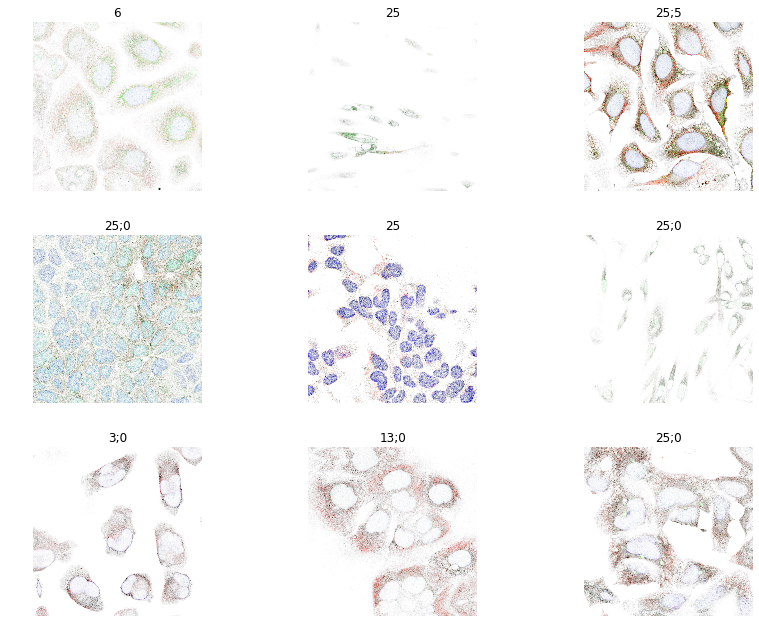

In [176]:
data.show_batch(rows=3, figsize=(12,9))

In [177]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [178]:
def _resnet_split(m): return (m[0][6],m[1])

In [179]:
class FocalLossStableLog(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.sum(dim=1).mean()

In [180]:
def acc(preds, targs, th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds == targs).float().mean()

In [181]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=FocalLossStableLog(),
    path=path,    
    metrics=[acc], 
)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 2e-2)

Total time: 08:48
epoch  train_loss  valid_loss  acc     
1      1.031124    0.900615    0.959124  (08:48)



In [28]:
learn.unfreeze()

In [29]:
lr = 2e-2

In [30]:
# lrs=np.array([lr/10,lr/3,lr])
learn.fit_one_cycle(8, slice(lr/10, lr))

Total time: 1:27:00
epoch  train_loss  valid_loss  acc     
1      0.964461    1.524998    0.939003  (11:02)
2      0.979762    0.995308    0.954780  (10:54)
3      0.981212    3.000085    0.956464  (10:52)
4      0.927040    1.076564    0.953940  (10:50)
5      0.833058    0.913493    0.961705  (10:51)
6      0.756648    0.858430    0.965975  (10:51)
7      0.711083    0.746613    0.968114  (10:48)
8      0.664723    0.733293    0.968884  (10:50)



In [31]:
learn.save('ResNet34_256_1')

In [182]:
_ = learn.load("foobar")

In [183]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, y = learn.TTA()

Total time: 32:04



In [184]:
preds_, y_ = preds.numpy(), y.numpy()

In [185]:
def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)

    score = 2.0 * (preds * targs).sum(axis=1) / ((preds + targs).sum(axis=1) + 1e-9)
    return score

def fit_val(x,y):
    params = 0.5 * np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x, y, p) - 1.0, wd * (p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [186]:
th = fit_val(preds_, y_)
th[th < 0.1] = 0.1
print('Thresholds: ', th)

th2 = [0.59375, 0.518, 0.59622, 0.60429, 0.621, 0.56779, 0.54318, 0.68052, 0.48651, 0.69849, 0.57524, 0.63268, 0.5997, 
       0.32272, 0.67099, 0.1, 0.52876, 0.51373, 0.53981, 0.57668, 0.51011, 0.506, 0.56507, 0.6476, 0.58579, 0.54278, 
       0.49447, 0.1]

print("Thresholds2: ", th2)

print('F1 macro: ',f1_score(y_, preds_ > th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y_, preds_ > 0.5, average='macro'))
print('F1 micro: ',f1_score(y_, preds_ > th, average='micro'))

print('F1 macro: ',f1_score(y_, preds_ > th2, average='macro'))
print('F1 micro: ',f1_score(y_, preds_ > th2, average='micro'))

/home/deep/fastai-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.394898 0.1      0.1
 0.1      0.540866 0.426155 0.1      0.382152 0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
 0.437425 0.5     ]
Thresholds2:  [0.59375, 0.518, 0.59622, 0.60429, 0.621, 0.56779, 0.54318, 0.68052, 0.48651, 0.69849, 0.57524, 0.63268, 0.5997, 0.32272, 0.67099, 0.1, 0.52876, 0.51373, 0.53981, 0.57668, 0.51011, 0.506, 0.56507, 0.6476, 0.58579, 0.54278, 0.49447, 0.1]
F1 macro:  0.5541386631407088
F1 macro (th = 0.5):  0.5231286849157232
F1 micro:  0.730269843061985
F1 macro:  0.515826579193577
F1 micro:  0.6933862911476198


In [187]:
preds_test, _ = learn.get_preds(DatasetType.Test)

In [ ]:
# def save_pred(pred, th=0.5, fname='protein_classification.csv'):
#     pred_list = []
#     for line in pred:
#         s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
#         pred_list.append(s)
        
#     sample_df = pd.read_csv(SAMPLE)
#     sample_list = list(sample_df.Id)
#     pred_dic = dict((key, value) for (key, value) 
#                 in zip(learner.data.test_ds.fnames,pred_list))
#     pred_list_cor = [pred_dic[id] for id in sample_list]
#     df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
#     df.to_csv(fname, header=True, index=False)

In [188]:
th_t = np.array([0.565, 0.39, 0.55, 0.345, 0.33, 0.39, 0.33, 0.45, 0.38, 0.39, 0.34,
                 0.42, 0.31, 0.38, 0.49, 0.50, 0.38, 0.43, 0.46, 0.40, 0.39, 0.505,
                 0.37, 0.47, 0.41, 0.545, 0.32, 0.1])

In [ ]:
# preds_sig = sigmoid_np(preds_test)

In [189]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > th_t)[0]])) for row in np.array(preds_test)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path / 'threasholded.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [190]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > th)[0]])) for row in np.array(preds_test)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path / 'threasholded_manual.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [191]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > th2)[0]])) for row in np.array(preds_test)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path / 'threasholded_kaggle.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [149]:
th = fit_val(preds_, y_)
th[th < 0.1] = 0.1
print('Thresholds: ', th)

th2 = [0.59375, 0.518, 0.59622, 0.60429, 0.621, 0.56779, 0.54318, 0.68052, 0.48651, 0.69849, 0.57524, 0.63268, 0.5997, 
       0.32272, 0.67099, 0.1, 0.52876, 0.51373, 0.53981, 0.57668, 0.51011, 0.506, 0.56507, 0.6476, 0.58579, 0.54278, 
       0.49447, 0.1]

print("Thresholds2: ", th2)

print('F1 macro: ',f1_score(y_, preds_ > th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y_, preds_ > 0.5, average='macro'))
print('F1 micro: ',f1_score(y_, preds_ > th, average='micro'))

print('F1 macro: ',f1_score(y_, preds_ > th2, average='macro'))
print('F1 micro: ',f1_score(y_, preds_ > th2, average='micro'))

/home/deep/fastai-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [0.1      0.1      0.1      0.1      0.145775 0.1      0.1      0.1      0.5      0.1      0.5      0.1      0.1
 0.1      0.1      0.5      0.5      0.5      0.1      0.1      0.1      0.1      0.1      0.1      0.1      0.1
 0.1      0.5     ]
Thresholds2:  [0.59375, 0.518, 0.59622, 0.60429, 0.621, 0.56779, 0.54318, 0.68052, 0.48651, 0.69849, 0.57524, 0.63268, 0.5997, 0.32272, 0.67099, 0.1, 0.52876, 0.51373, 0.53981, 0.57668, 0.51011, 0.506, 0.56507, 0.6476, 0.58579, 0.54278, 0.49447, 0.1]
F1 macro:  0.38194122731067914
F1 macro (th = 0.5):  0.2766635626595583
F1 micro:  0.6673849284730952
F1 macro:  0.26035851514552205
F1 micro:  0.4783726224572226


In [120]:
def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)

#     eps = 1e-9
#     TP = (preds * targs).sum(axis=1)
#     prec = TP/(preds.sum(axis=1)+eps)
#     rec = TP/(targs.sum(axis=1)+eps)
#     res = (prec * rec) / (prec * 4 + rec + eps) * ( 1 + 4)

    score = 2.0 * (preds * targs).sum(axis=1) / ((preds + targs).sum(axis=1) + 1e-9)
    return score #, res.mean()

def fit_val(x,y):
    params = 0.5 * np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x, y, p) - 1.0, wd * (p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p